In [300]:
%run 00_background.ipynb

First off all data driven model designes heavily relies on data. Because of this first data representing the task, in the form of input data and prediction result has to collected, which can then be used to train the models.

For the examples here the data is a mixture of multiple available datasets:
- blah
- blah2

All of the datasets have in common, that they contain molecular representations of the repective molecular structure as a SMILES string. 


In [301]:
dataset

,DTXSID,name,CASRN,INCHIKEY,IUPAC_NAME,SMILES,INCHI_STRING,MOLECULAR_FORMULA,AVERAGE_MASS,MONOISOTOPIC_MASS,DATA_SOURCES,NUMBER_OF_PUBMED_ARTICLES,PUBCHEM_DATA_SOURCES,CPDAT_COUNT,rd_mol,molar_mass,pre_graphs,hybridization
0,DTXSID7020009,Acetonitrile,75-05-8,WEVYAHXRMPXWCK-UHFFFAOYSA-N,Acetonitrile,CC#N,InChI=1S/C2H3N/c1-2-3/h1H3,C2H3N,41.053,41.026549101,165.0,3174.0,1110,318,"<img data-content=""rdkit/molecule"" src=""data:i...",41.053,"(0, 1, 2, 3, 4, 5)","[[False, False, False, False, False, True, Fal..."
1,DTXSID5020023,Acrolein,107-02-8,HGINCPLSRVDWNT-UHFFFAOYSA-N,Prop-2-enal,C=CC=O,"InChI=1S/C3H4O/c1-2-3-4/h2-3H,1H2",C3H4O,56.064,56.026214749,189.0,2468.0,139,30,"<img data-content=""rdkit/molecule"" src=""data:i...",56.064,"(0, 1, 2, 3, 4, 5, 6, 7)","[[False, False, False, False, False, True, Fal..."
2,DTXSID0020024,Acrolein diethylacetal,3054-95-3,MCIPQLOKVXSHTD-UHFFFAOYSA-N,"3,3-Diethoxyprop-1-ene",C=CC(OCC)OCC,"InChI=1S/C7H14O2/c1-4-7(8-5-2)9-6-3/h4,7H,1,5-...",C7H14O2,130.187,130.099379691,45.0,1.0,100,-,"<img data-content=""rdkit/molecule"" src=""data:i...",130.187,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[False, False, False, False, False, True, Fal..."
3,DTXSID5020029,Acrylonitrile,107-13-1,NLHHRLWOUZZQLW-UHFFFAOYSA-N,Prop-2-enenitrile,C=CC#N,"InChI=1S/C3H3N/c1-2-3-4/h2H,1H2",C3H3N,53.064,53.026549101,195.0,1092.0,168,582,"<img data-content=""rdkit/molecule"" src=""data:i...",53.064,"(0, 1, 2, 3, 4, 5, 6)","[[False, False, False, False, False, True, Fal..."
4,DTXSID8020044,Allyl alcohol,107-18-6,XXROGKLTLUQVRX-UHFFFAOYSA-N,Prop-2-en-1-ol,C=CCO,"InChI=1S/C3H6O/c1-2-3-4/h2,4H,1,3H2",C3H6O,58.08,58.041864813,153.0,627.0,152,2,"<img data-content=""rdkit/molecule"" src=""data:i...",58.080,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)","[[False, False, False, False, False, True, Fal..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3851,DTXSID30996806,(6-Methylheptan-2-yl)hydrazine,7535-34-4,WAYKZORTCXXXDO-UHFFFAOYNA-N,(6-Methylheptan-2-yl)hydrazine,CC(C)CCCC(C)NN,"InChI=1/C8H20N2/c1-7(2)5-4-6-8(3)10-9/h7-8,10H...",C8H20N2,144.262,144.162648652,6.0,-,-,-,"<img data-content=""rdkit/molecule"" src=""data:i...",144.262,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[False, False, False, False, False, True, Fal..."
3852,DTXSID10998848,2-Chlorooxirane,7763-77-1,WBNCHVFLFSFIGK-UHFFFAOYNA-N,2-Chlorooxirane,ClC1CO1,"InChI=1/C2H3ClO/c3-2-1-4-2/h2H,1H2",C2H3ClO,78.5,77.9872424,6.0,-,-,-,"<img data-content=""rdkit/molecule"" src=""data:i...",78.498,"(0, 1, 2, 3, 4, 5, 6)","[[False, False, True, False, False, False, Fal..."
3853,DTXSID20999144,2-[(Butan-2-yl)oxy]ethan-1-ol,7795-91-7,HUWFDQSAXOIUNP-UHFFFAOYNA-N,2-[(Butan-2-yl)oxy]ethan-1-ol,CCC(C)OCCO,"InChI=1/C6H14O2/c1-3-6(2)8-5-4-7/h6-7H,3-5H2,1...",C6H14O2,118.176,118.099379691,11.0,-,-,-,"<img data-content=""rdkit/molecule"" src=""data:i...",118.176,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[False, False, False, False, False, True, Fal..."
3854,DTXSID70999775,2-Methyl-1-[(propan-2-yl)oxy]propane,78448-33-6,HIIBZFKVMXEQMR-UHFFFAOYSA-N,2-Methyl-1-[(propan-2-yl)oxy]propane,CC(C)COC(C)C,"InChI=1S/C7H16O/c1-6(2)5-8-7(3)4/h6-7H,5H2,1-4H3",C7H16O,116.204,116.120115135,3.0,-,-,-,"<img data-content=""rdkit/molecule"" src=""data:i...",116.204,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[False, False, False, False, False, True, Fal..."


Th smile string is then programatically transformed in a node featurzed graph representation $G(N,E)$.
Meaning that for each atom a node (or vertex) $N$ is created and for each bond an edge $E$ is created. Usually the eges are featurless and thus there will be no distinction between different bond orders.
Each node can be represented by a feature vector $f$ who's values are specific properties of the atom represented by the node, *e.g.*  atomic mass, charge, hybridization, number of connected atoms, atom type. All properties should be directly calculatable and representable by a numerical value. Categorical features like atom type should be represented as one-hot encoded vectors (1 for the specific type and 0 for all others), and not e.g. as integer types (1 for H, 2 for He,...), since this would introduce an natural order which is not a good representation in many cases (Carbon is not 12 times hydrogen, when prediction values like electro negativity). On the other hand from a one-hot-encoded vector it is possible for the model to learn such an order if necessary (see second example).

**some more explain** 

#### Example 1 - Molar mass from atom masses
First we start with a simple example by predicting the molar masses of random molecules from the dataset. As a featurization the mass of each individual atom was used. As a result, to get the molar mass of each respective molecule all features (individual atomic masses) have to be added. 
The process to sum all features together is basically one possibillity for a pooling operation. pooling is usally done at the end of a graph convolution to bring an arbitary shaped graph to an fixed size vecor.
Basic pooling operation are operations to calculate scalar parameters like location parameter (*e.g*.minimum, maximm, average) or the sum over every dimension of the final features of the graph. This results in a vector of a size equal to the number of final features, which is a fixed hyperparameter for the models.
$$f=\Theta(f_0,f_1,...f_{N})$$

If we just perform a simple sum pooling over the inital graph features without any graph convolution or any other layer holding trainable parameters the model is without any trainable parameters and thus training is not necessary (nor possible):

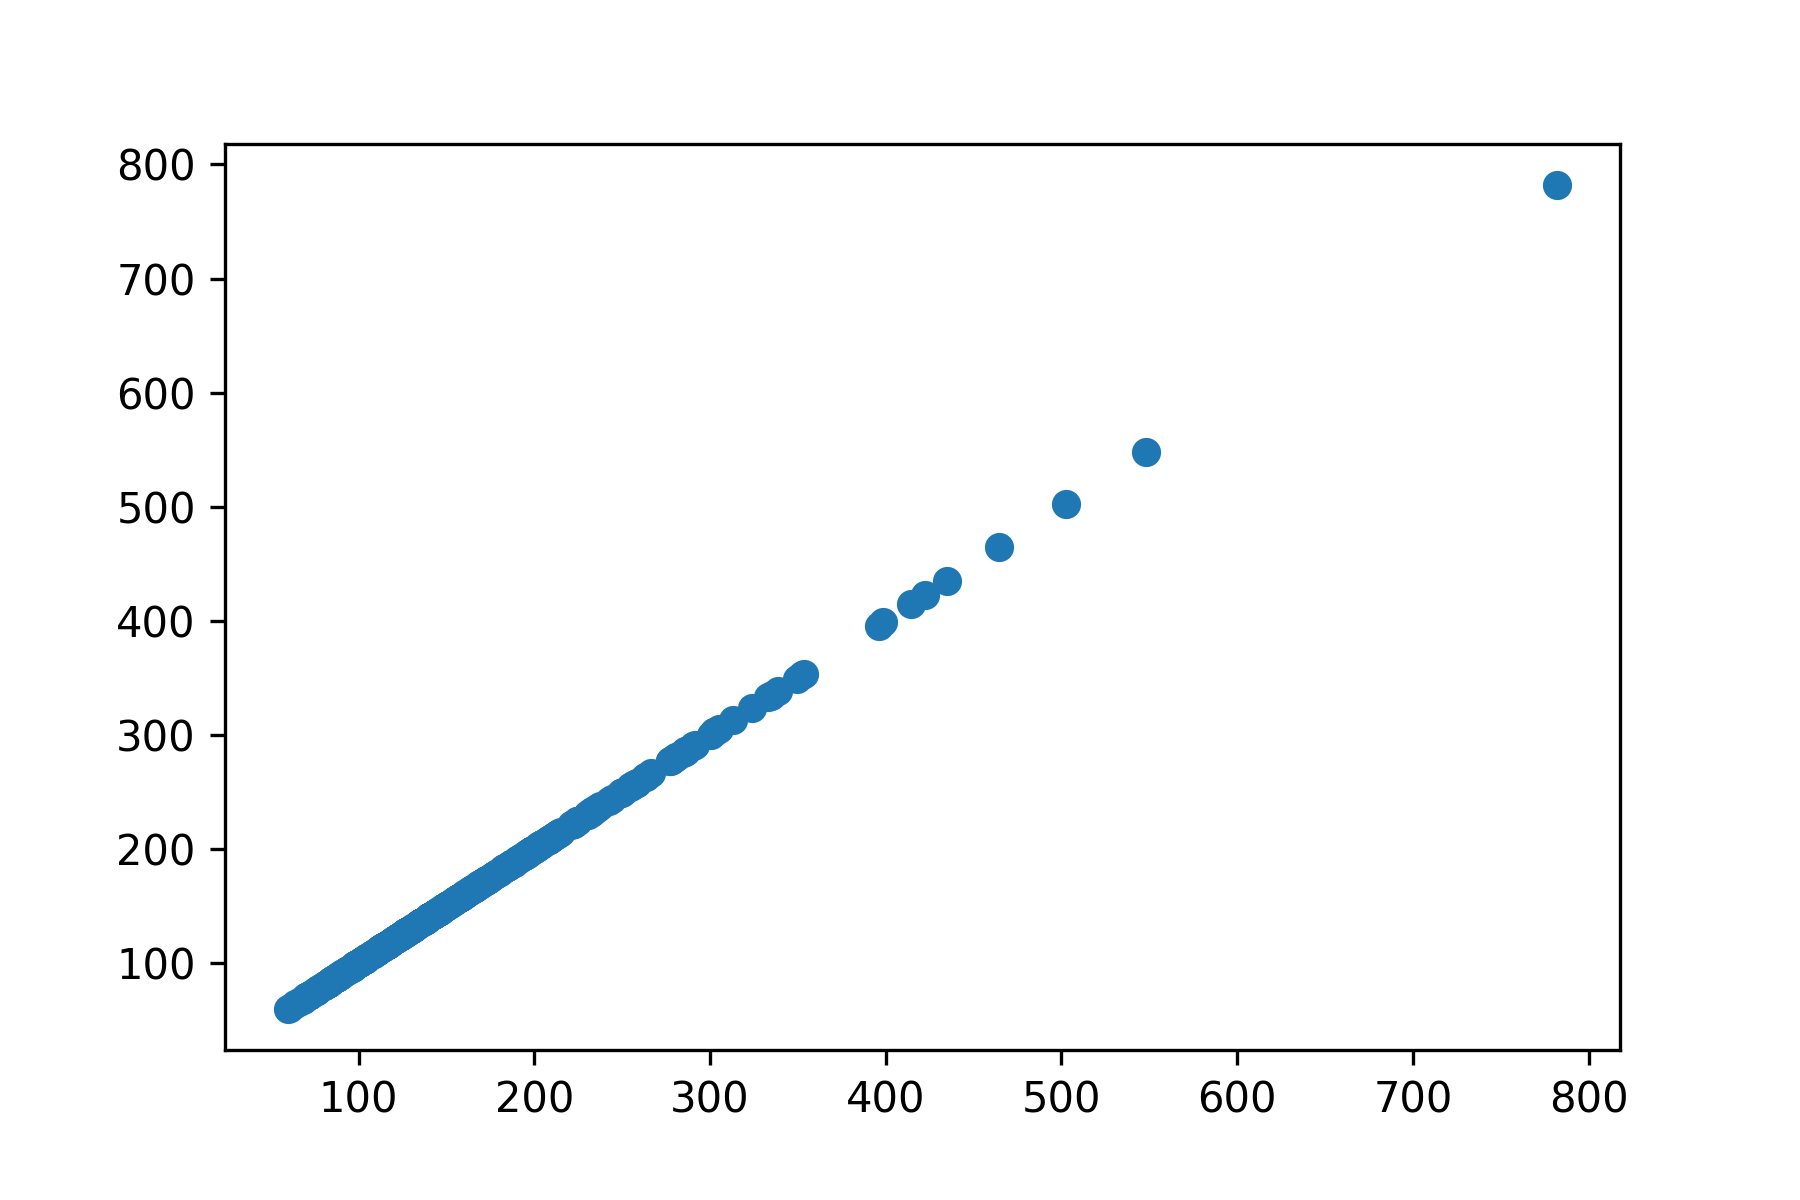

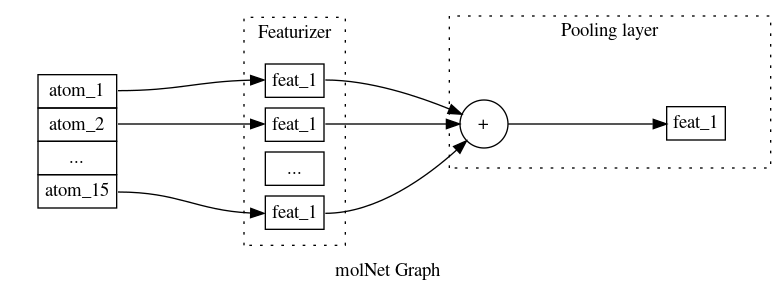

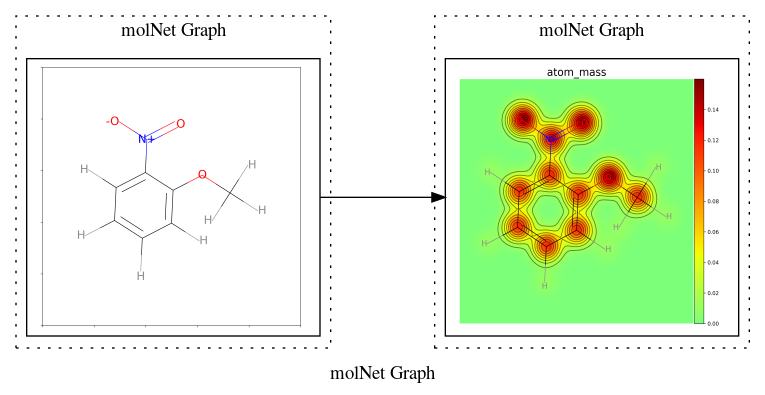

In [313]:
from molNet.nn.models.graph_convolution import PoolSum
from molNet.dataloader.molecule_loader import PytorchGeomMolGraphFromGeneratorLoader, PytorchGeomMolGraphGenerator, PytorchGeomMolGraphFromDfLoader
from molNet.featurizer.atom_featurizer import atom_mass

class SimpleSumAtomMassesModel(pl.LightningModule):
    def __init__(self,name="none"):
        super().__init__()
        self.save_hyperparameters()
        self.pooling =PoolSum()

    def unpacked_forward(self, feats, edges, batch,graph_features):
        feats = self.pooling(feats, batch)
        return feats*100

    def forward(self,batch):
        return self.unpacked_forward(feats=batch.x,edges=batch.edge_index,batch=batch.batch,graph_features=batch.graph_features)
    
    def to_graphviz_images_from_batch(self,batch,path,name=None):
        if name is None:
            name=self.__class__.__name__
        parent=molNetGraphviz(name=name,reduced=False)
        parent.attr(nodesep="0", ranksep="1.3")
        
        rdkit.Chem.Draw.MolToMPL(batch.mol_graph[0].mol)
        _atom_ip_img = os.path.join(path,name+"_atom_ip.png")
        plt.savefig(_atom_ip_img,dpi=DEFAULT_DPI, bbox_inches = 'tight')
        plt.close()
        ip = molNetGraphviz(name=name+"_ip",parent=parent)
        ipn=name+"_ip_node"
        ip.node(ipn,table_node([[(0,"")]],image=_atom_ip_img)
               )        
        parent.subgraph(ip)
    
    
        fg_img=plot_features_to_mol(batch.to_data_list()[0].x.numpy(),batch.mol_graph[0].mol,atom_mass.describe_features(),
                            plot=False,
                             path=path,
                             prefix=" fg_"
                            )
        
        fg = molNetGraphviz(parent=aig,name=name+"featurize",)
        for i,fgi in enumerate(fg_img):
            nn="{}_fg_node_{}".format(name,i)
            fg.node(nn,table_node([[(0,"")]],image=fgi)
               )  
            fg.edge(ipn,nn)
            
        parent.subgraph(fg)
        
        return parent
    
    def to_graphviz_from_batch(self,batch=None,reduced=False,name=None,feat_images=False,path=None):
        if name is None:
            name=self.__class__.__name__
        if batch is None:
            features=4
            mol=None
        else:
            mol = batch.to_data_list()[0]
            features=mol.x.shape[1]
        
        
        if feat_images:
            reduced=False
            if path is None:
                raise AttributeError("feat_images is True but no path specified")
        
        parent=molNetGraphviz(name=name,reduced=reduced)
        parent.attr(nodesep="0", ranksep="1.3")
        
        
        aig = AtomInputGraph(name=name+"_atom_ip",parent=parent,
                             img = _atom_ip_img if feat_images else None)
        parent.subgraph(aig)


            
        fg = FeaturizerGraph(aig,features,name=name+"featurize",
                            )
        parent.subgraph(fg)

        pg = self.pooling.to_graphviz(fg,name=name+"pool")
        parent.subgraph(pg)
        
        return parent
        
            
        
    
# no parameter and thus no training necessary
model_SimpleSumAtomMassesModel = SimpleSumAtomMassesModel()


loader_SimpleSumAtomMassesModel = PytorchGeomMolGraphFromDfLoader(dataset,smiles_column='SMILES',additional_data=['name'],#"all",
                                         y_properties=["molar_mass"],
                                         #seed=SEED,
                                         to_graph_params={"atom_featurizer":atom_mass,"with_mol_graph":True},
                                        batch_size=32
                                        )

model_SimpleSumAtomMassesModel,data_SimpleSumAtomMassesModel = default_model_run(
    "SimpleSumAtomMassesModel",
    model_SimpleSumAtomMassesModel,
    loader_SimpleSumAtomMassesModel,
    force_run=REMODEL,
    detect_lr=False,
    show_tb=False,
    train=False,
    save=False,
    ignore_load_error=not REMODEL
)

In [ ]:
model_SimpleSumAtomMassesModel.feature_mol_image_graphviz(data_SimpleSumAtomMassesModel["test_batch"],"test")

As can be seen the model performs perfectly, which is expected since the result of the pooling has matches the real mass of the underlying molecule.

#### Example 2 - Molar mass from atom types
If the featurizer is replaced with an atom type featurizer simple pooling cannot be applied any more. Nontheless graph convolution is still not necessary since the most basic approch is to somehow get the mass of each atom and then just apply the sum as in the previous example.

One possibility to to so is by using a weighted sum, where each summand is multiplied with a trainable parameter before summation:
$$f=\sum_{i=0}^{N}{w_i*f_i}$$

From a machine learning perspective this is the same as a one of the simplest fully connected neuronal networks with no hidden layers, no bias and only a single output value:

In [ ]:
sf = "img/weightsum.png"
if not os.path.exists(sf) or REDRAW:
    plot_fcnn([8,1],(np.random.randint(4,10,8)/10).reshape(1,1,8),show_bar=False,input_array=np.random.random(8)-0.5,save=sf)
display(Image(sf,width=DEFAULT_IMG_PLOT_WIDTH))
display(md(
    "The resulting model contains as many trainable parameters as there are initial features ({}), "
    "where each feature describes whether the atom that is featurized is one of the following atoms (0 or 1):"
    .format(len(c_atom_symbol_featurizer))))

atom_list=[f.replace("custom_atom_symbol_one_hot: ","").replace("None","other") for f in c_atom_symbol_featurizer.describe_features()]
display(atom_list)

A carbon atom whould thus be represented by the feature vector:

In [ ]:
list(np.array(c_atom_symbol_featurizer(Chem.Atom("C")))*1)

Note that the featurizer does not featurize all possible atom types but was created to only featurize atoms which are present in the dataset to reduce the size of the model and make it easier to vizualize.

It only takes a few epochs (iterations over the training data) for the model to completly tune the weights of the weighted-sum-network, resulting in a nearly perfect prediction.

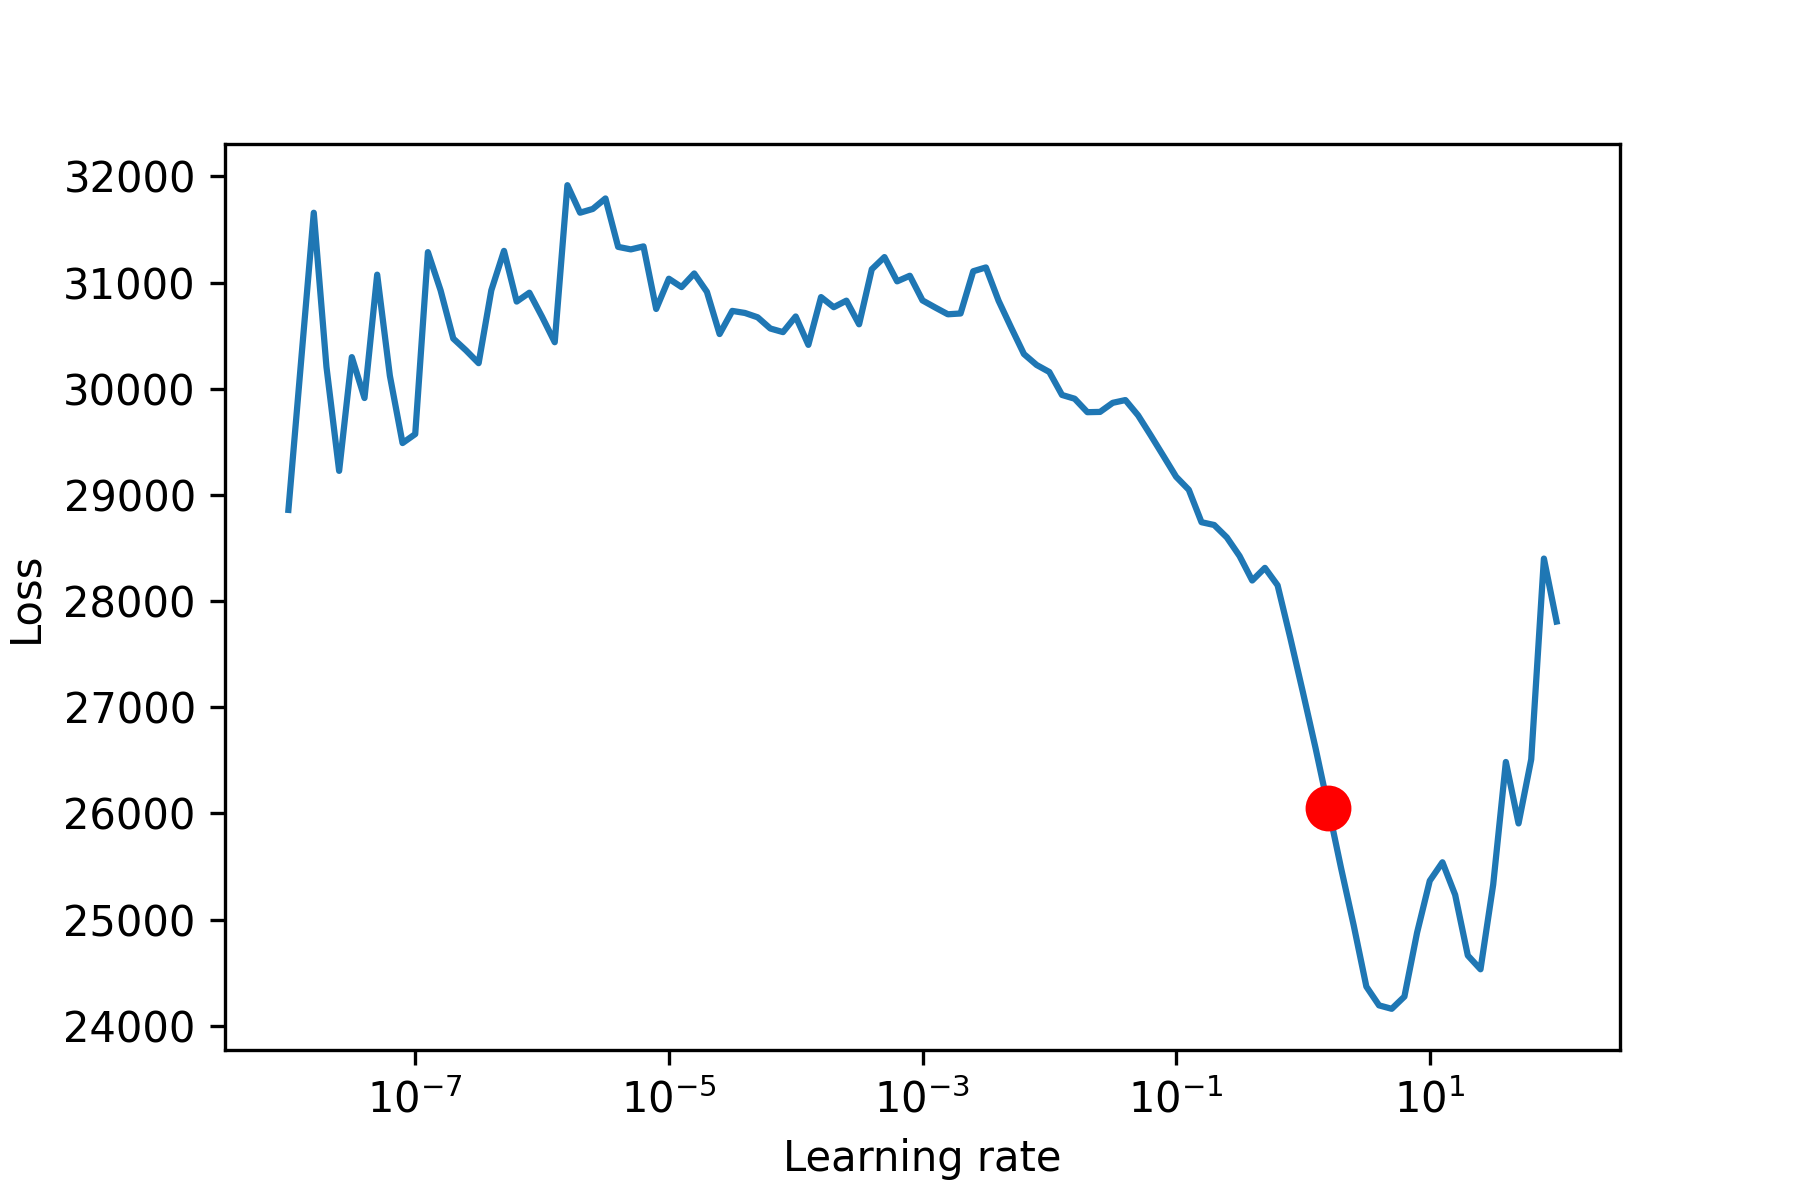

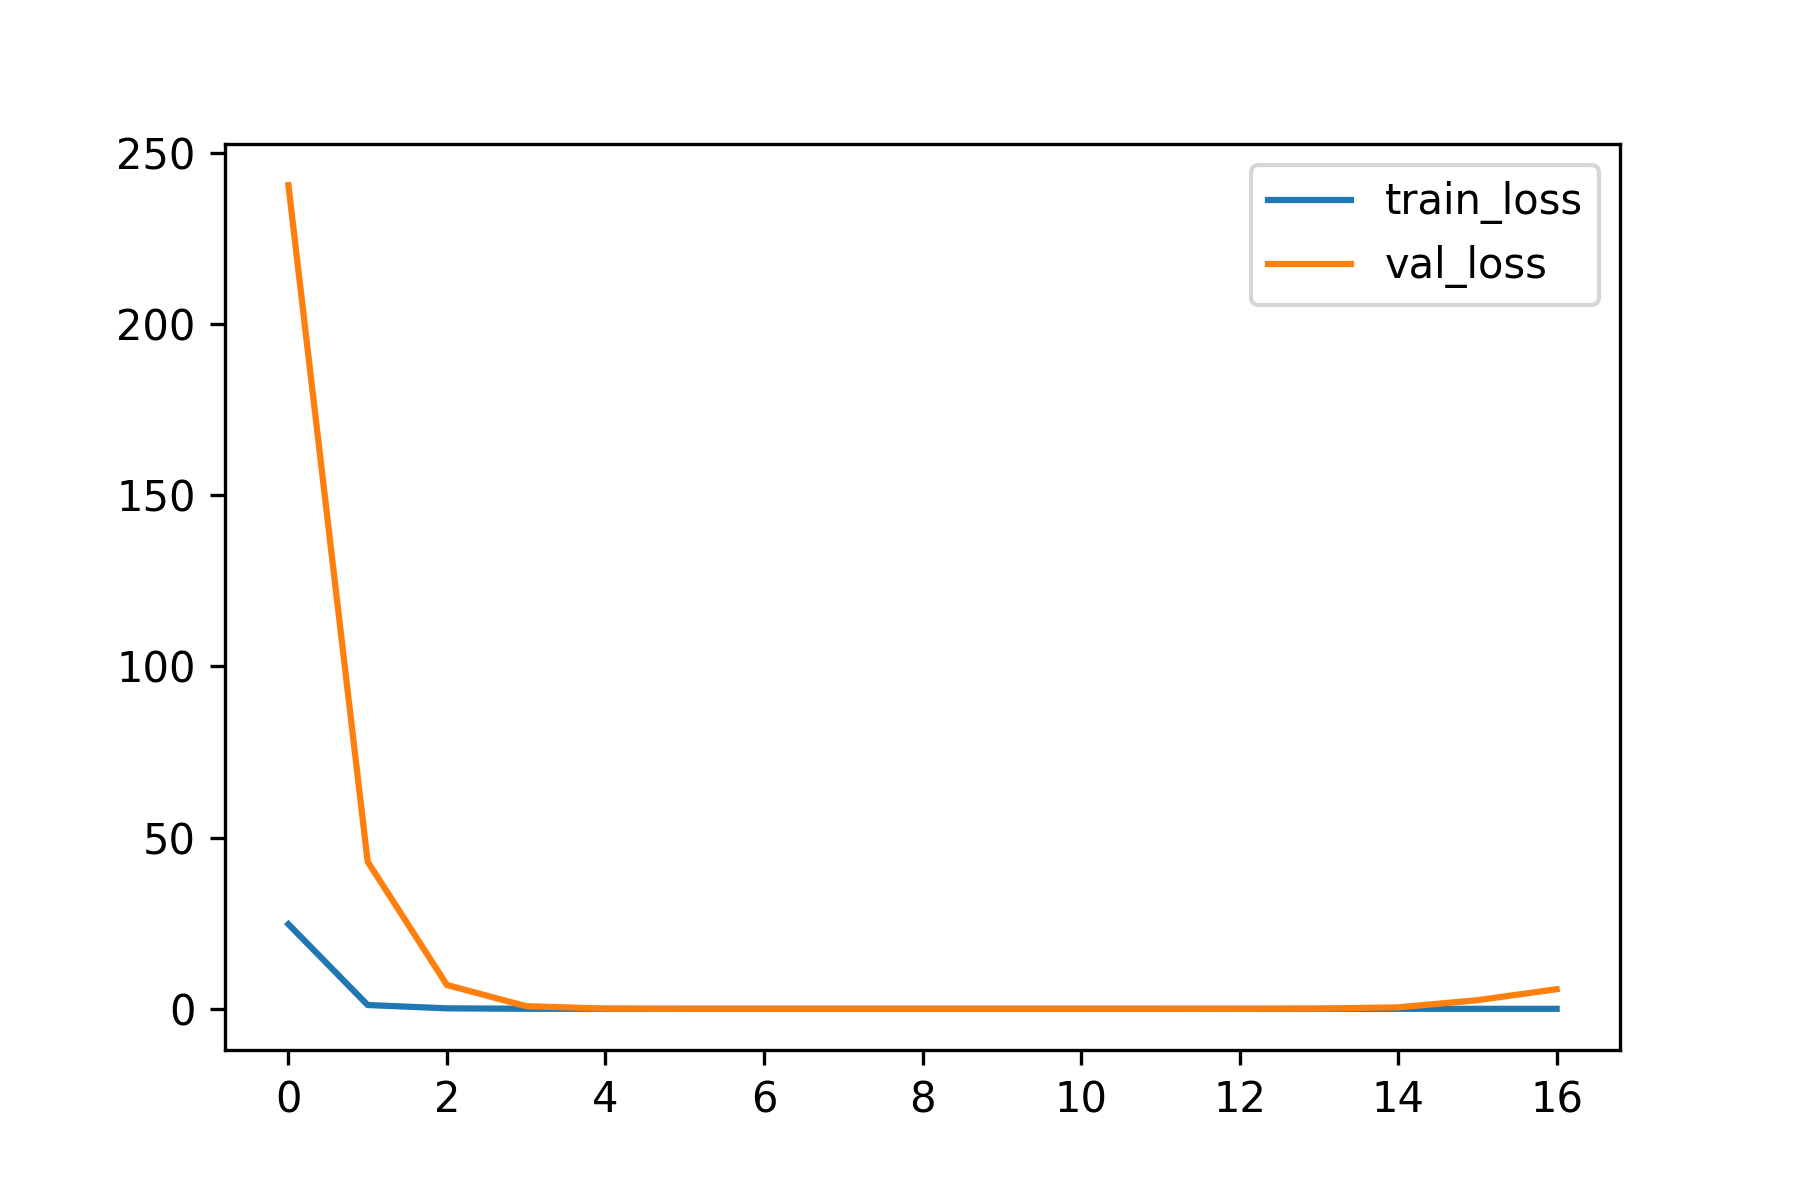

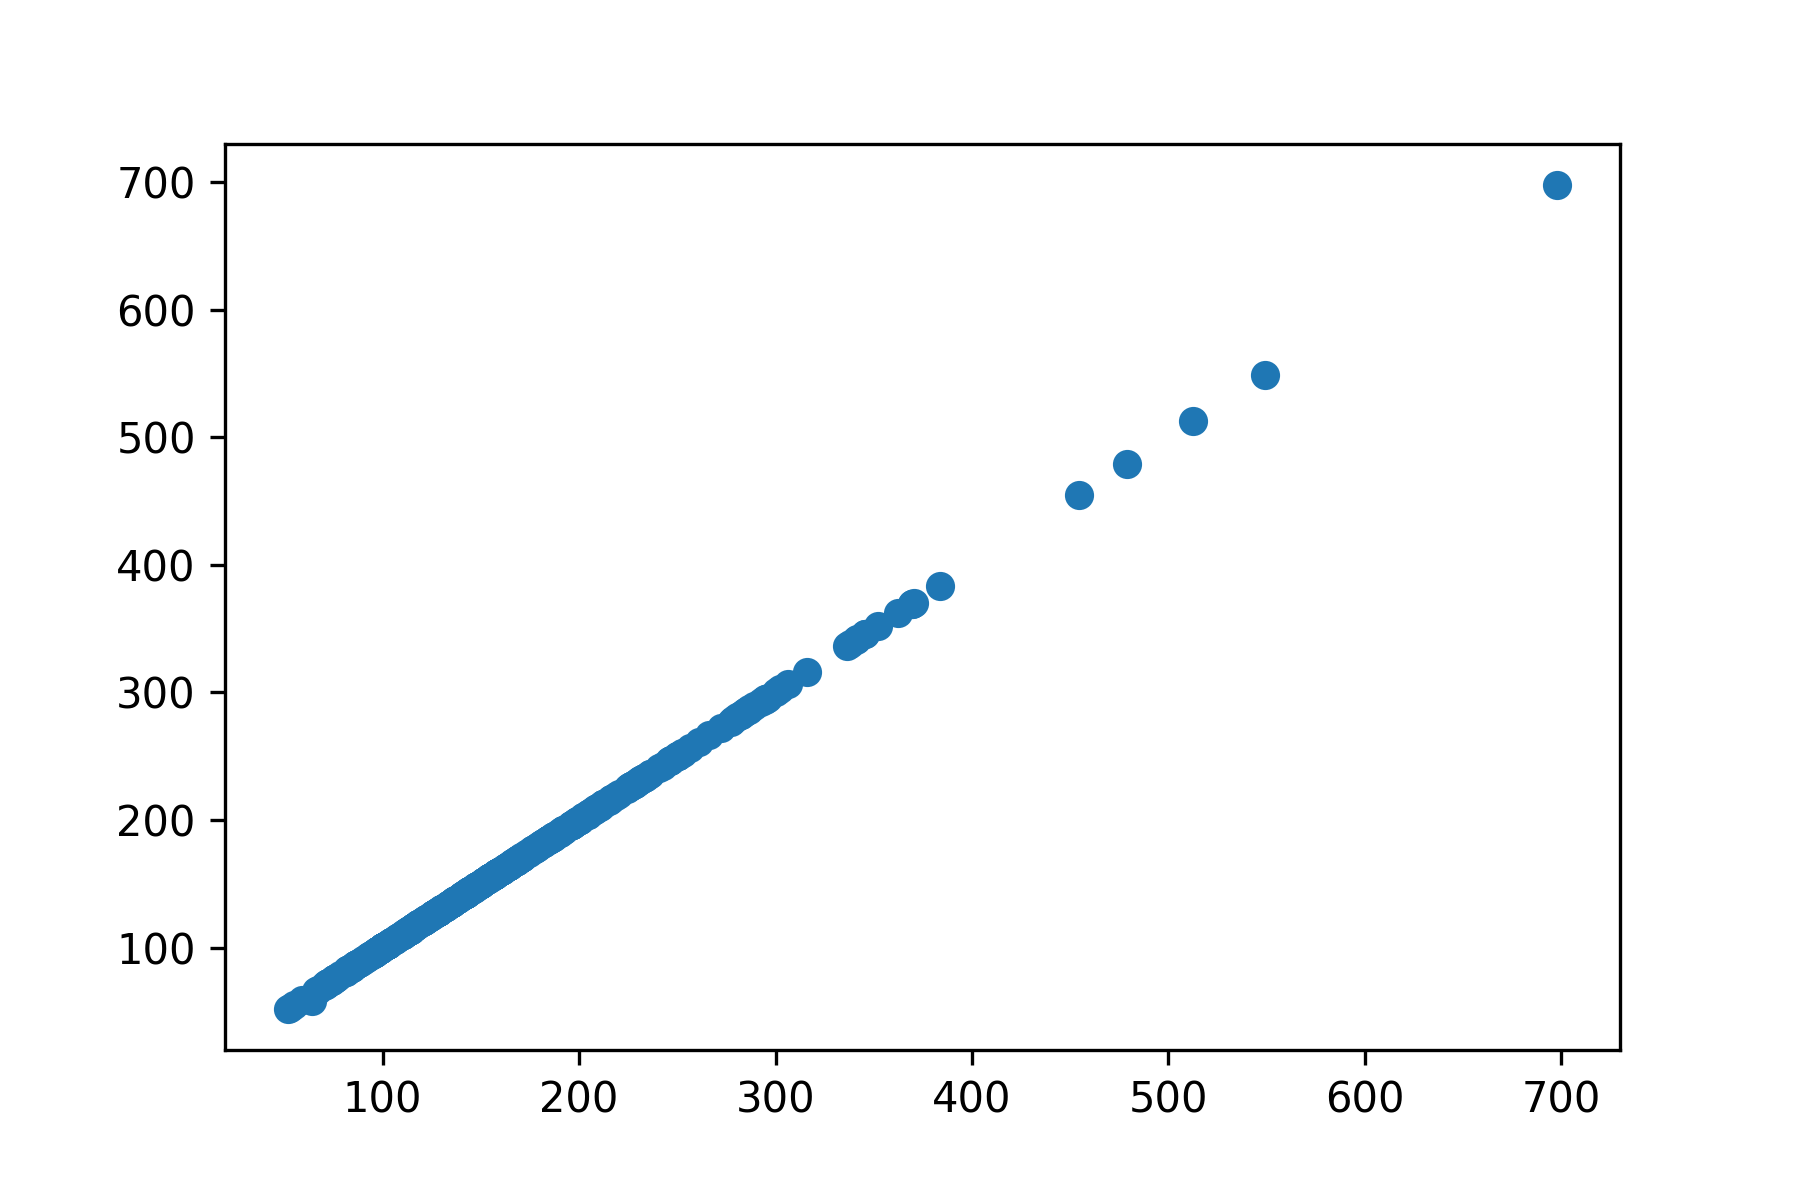

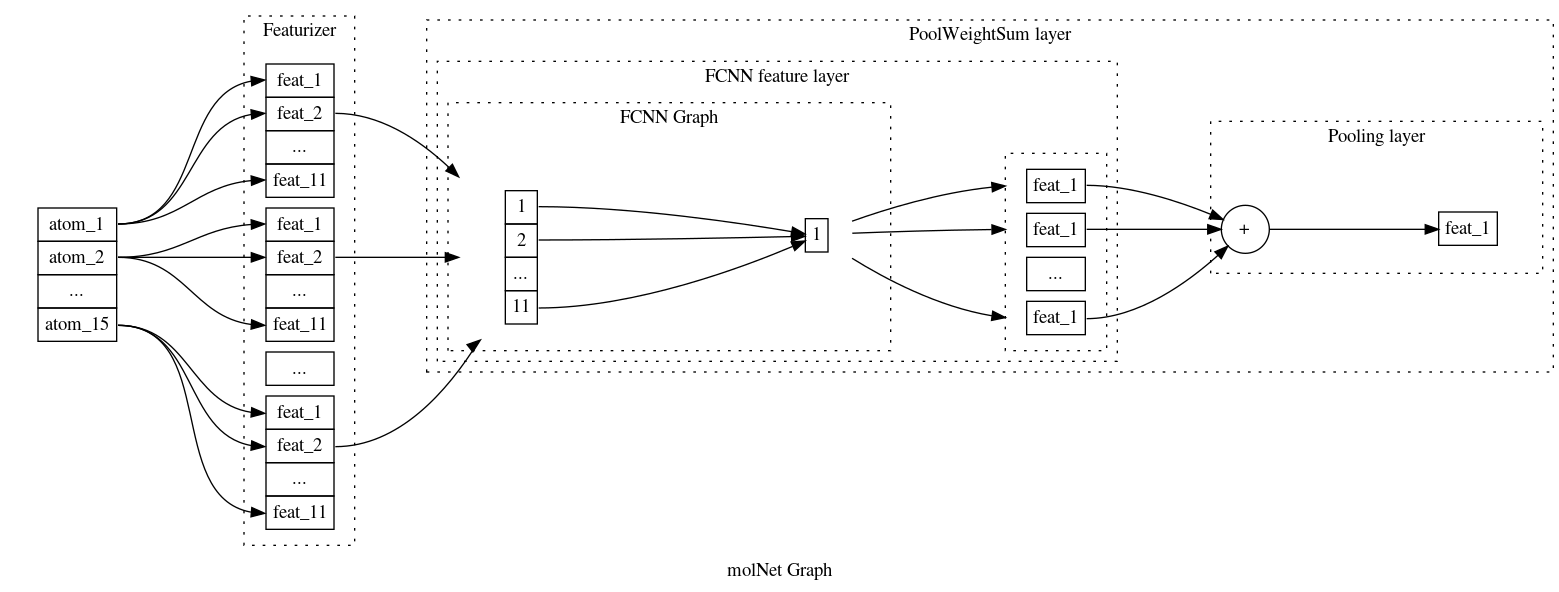

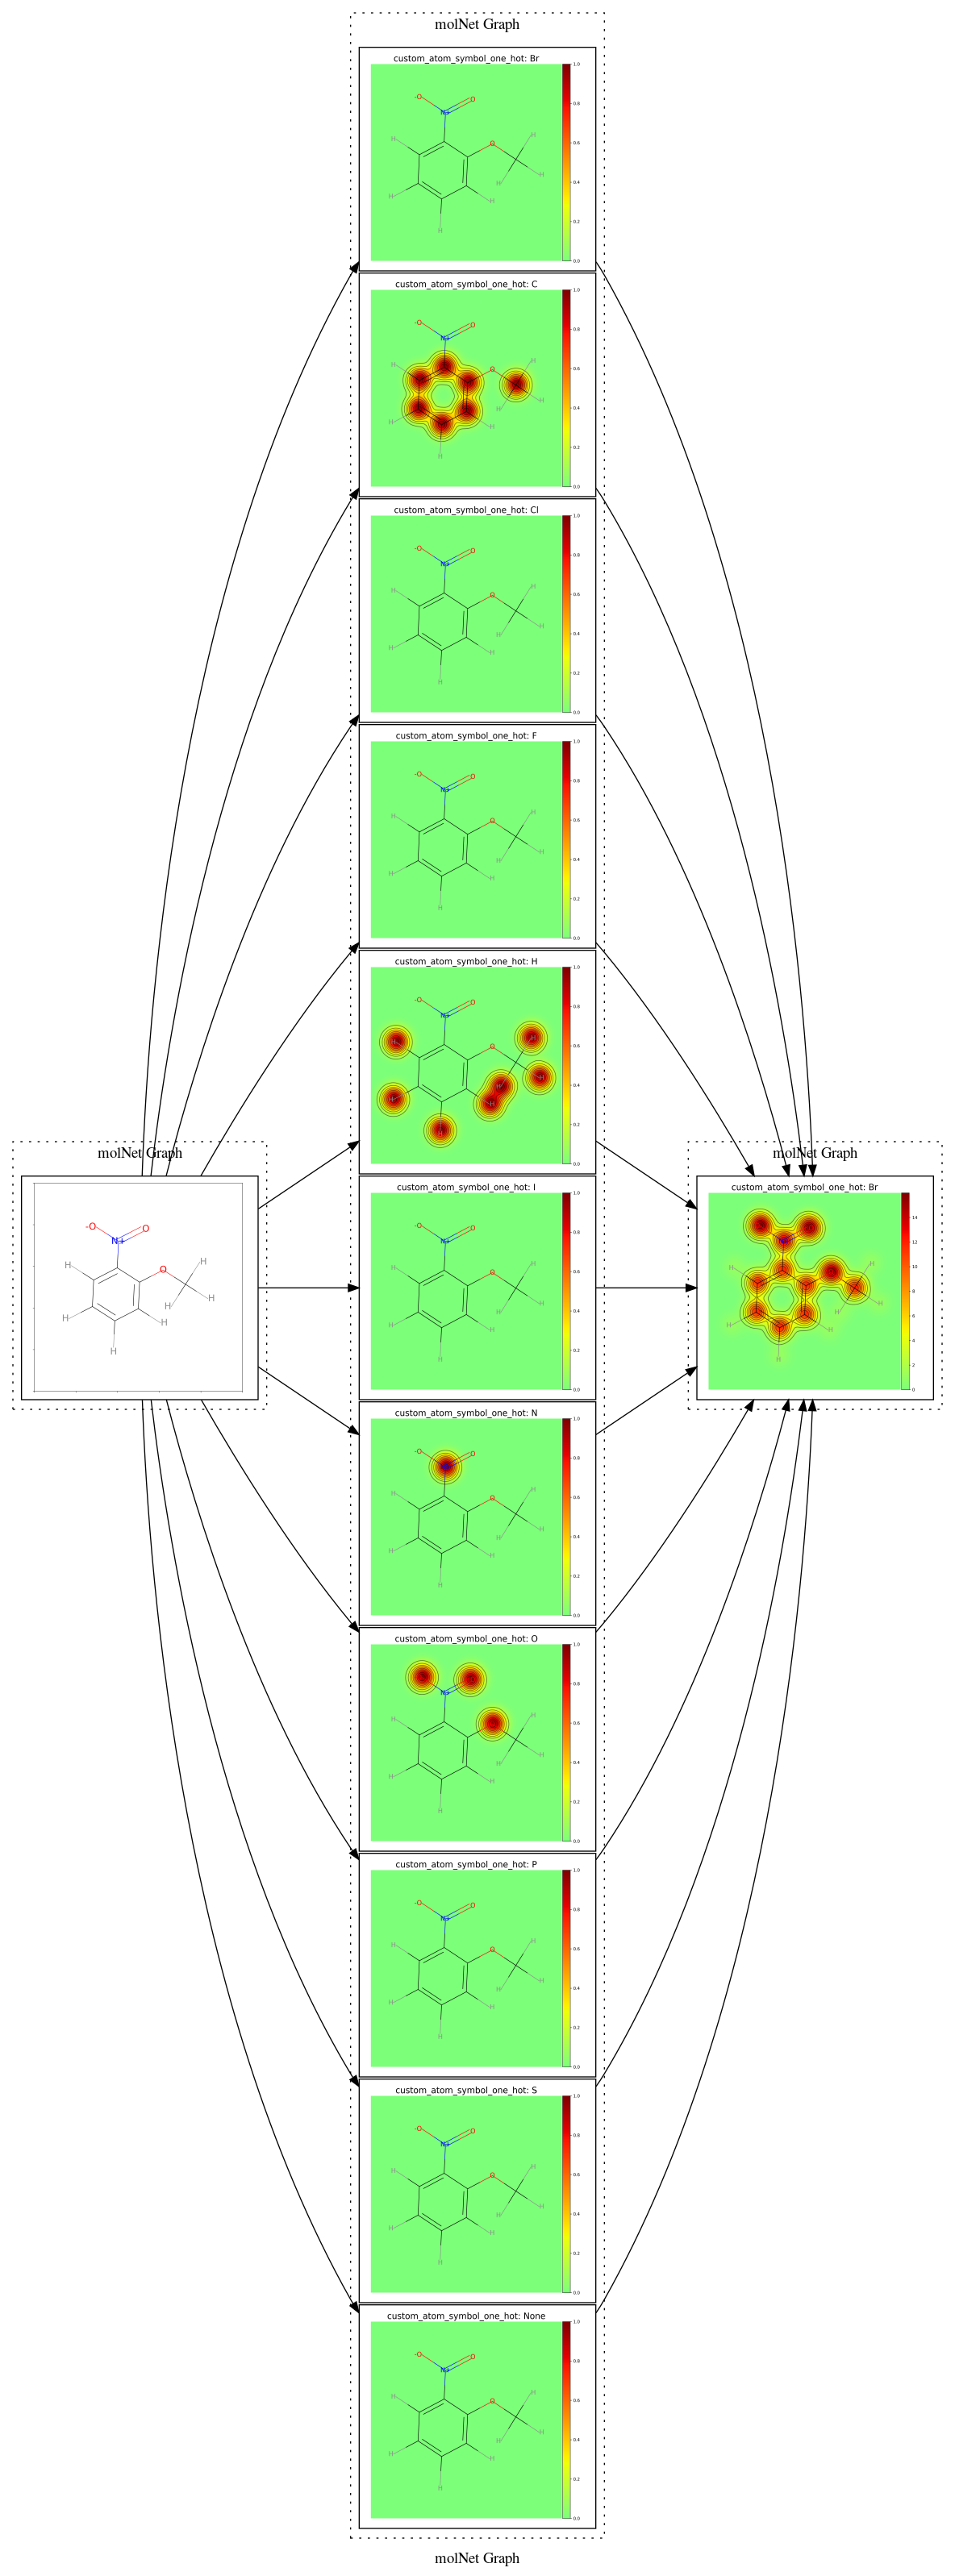

In [319]:
from molNet.featurizer.atom_featurizer import atom_symbol_one_hot
from torch_geometric.nn import GCNConv, GlobalAttention,global_add_pool
from molNet.nn.models.graph_convolution import PoolWeightedSum, PoolSum
import torch.nn.functional as F
import molNet.nn.functional as mF


class MolWeigtFromTypeModel(pl.LightningModule):
    def __init__(self,in_size,name="none"):
        super().__init__()
        self.save_hyperparameters()
        self.pooling = PoolWeightedSum(in_size,normalize=False,bias=False)
        self.lr = 1e-1

    def unpacked_forward(self, feats, edges, batch,graph_features):
        feats = self.pooling(feats, batch)
        feats = torch.sum(feats,dim=1,keepdim=True)
        return feats

    def forward(self,batch):
        return self.unpacked_forward(feats=batch.x,edges=batch.edge_index,batch=batch.batch,graph_features=batch.graph_features)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    
    def training_step(self,batch, *args, **kwargs):
        y_hat=self(batch)
        #print(y_hat.shape)
        #print(batch.y.shape)
        #raise ValueError()
        loss =  F.mse_loss(y_hat, batch.y)#mF.rell1_loss(y_hat, batch.y)*100
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self,batch, *args, **kwargs):
        y_hat=self(batch)
        loss =  F.mse_loss(y_hat, batch.y)#mF.rell1_loss(y_hat, batch.y)*100
        self.log('val_loss', loss)
        return loss
    
    def test_step(self,batch, *args, **kwargs):
        y_hat=self(batch)
        loss =  F.mse_loss(y_hat, batch.y)#mF.rell1_loss(y_hat, batch.y)*100
        self.log('test_loss', loss)
        return loss
    
    
    def to_graphviz(self,feature_graph,reduced=False,name=None):
        return self.pooling.to_graphviz(feature_graph,name=name+"pool")
        
    
    def to_graphviz_images_from_batch(self,batch,path,name=None):
        if name is None:
            name=self.__class__.__name__
        parent=molNetGraphviz(name=name,reduced=False)
        parent.attr(nodesep="0", ranksep="1.3")
        
        rdkit.Chem.Draw.MolToMPL(batch.mol_graph[0].mol)
        _atom_ip_img = os.path.join(path,name+"_atom_ip.png")
        plt.savefig(_atom_ip_img,dpi=DEFAULT_DPI, bbox_inches = 'tight')
        plt.close()
        ip = molNetGraphviz(name=name+"_ip",parent=parent)
        ipn=name+"_ip_node"
        ip.node(ipn,table_node([[(0,"")]],image=_atom_ip_img)
               )        
        parent.subgraph(ip)
    
    
        fg_img=plot_features_to_mol(batch.to_data_list()[0].x.numpy(),batch.mol_graph[0].mol,c_atom_symbol_featurizer.describe_features(),
                            plot=False,
                             path=path,
                             prefix=" fg_"
                            )
        
        fg = molNetGraphviz(parent=aig,name=name+"featurize",)
        fg_names=[]
        for i,fgi in enumerate(fg_img):
            nn="{}_fg_node_{}".format(name,i)
            fg_names.append(nn)
            fg.node(nn,table_node([[(0,"")]],image=fgi)
               )  
            fg.edge(ipn,nn)
        parent.subgraph(fg)
        
        fgpool_img=plot_features_to_mol(self.pooling.weighting_of_nodes(batch.to_data_list()[0].x).detach().numpy(),batch.mol_graph[0].mol,c_atom_symbol_featurizer.describe_features(),
                            plot=False,
                             path=path,
                             prefix=" fgpool_"
                            )
        
        fgpool = molNetGraphviz(parent=aig,name=name+"fg_pool",)
        for i,fgi in enumerate(fgpool_img):
            nn="{}_fgp_node_{}".format(name,i)
            fgpool.node(nn,table_node([[(0,"")]],image=fgi)
               )  
            for fn in fg_names:
                fgpool.edge(fn,nn)
        
        parent.subgraph(fgpool)
        
        return parent
            
    def to_graphviz_from_batch(self,batch=None,reduced=False,name=None):
        if name is None:
            name=self.__class__.__name__
        
        if batch is None:
            features=4
            mol=None
        else:
            mol = batch.to_data_list()[0]
            features=mol.x.shape[1]
            
        parent=molNetGraphviz(name=name,reduced=reduced)
        parent.attr(nodesep="0", ranksep="1.3")

    
            
        
        aig = AtomInputGraph(name=name+"_atom_ip",parent=parent)
        
        parent.subgraph(aig)

        fg = FeaturizerGraph(aig,len(c_atom_symbol_featurizer),name=name+"featurize")
        parent.subgraph(fg)

        
        parent.subgraph(self.to_graphviz(fg,reduced,name))
        
        return parent
    

loader_MolWeigtFromTypeModel = PytorchGeomMolGraphFromDfLoader(dataset,smiles_column='SMILES',additional_data=['name'],#"all",
                                     y_properties=["molar_mass"],
                                     seed=2,
                                     to_graph_params={"atom_featurizer":c_atom_symbol_featurizer,"with_mol_graph":True},
                                    batch_size=32,#num_workers=4
                                    )
model_MolWeigtFromTypeModel = MolWeigtFromTypeModel(in_size=len(c_atom_symbol_featurizer))

model_MolWeigtFromTypeModel,data_MolWeigtFromTypeModel = default_model_run(
    "MolWeigtFromTypeModel",
    model_MolWeigtFromTypeModel,
    loader_MolWeigtFromTypeModel,
                  force_run=REMODEL,
                  force_test_data_reload=False
                               #min_epochs=15
                 )

In [ ]:
model_MolWeigtFromTypeModel.feature_mol_image_graphviz(data_MolWeigtFromTypeModel["test_batch"],"")

In [ ]:
from rdkit.Chem.Draw import SimilarityMaps
display(md("sample molecule:"))
sf = os.path.join(data_MolWeigtFromTypeModel["files"]['plot_dir'],"sample_mol.svg")
if not os.path.exists(sf) or REDRAW:
    svg=data_MolWeigtFromTypeModel["test_data"].mol_graph.molecule.to_svg()
    with open(sf,"w+") as f:
        f.write(svg)
display(SVG(sf))


prec=4

display(md("true (calculated) mass: {} and predicted mass {}".format(
    data_MolWeigtFromTypeModel["test_data"].y[0][0],
    model_MolWeigtFromTypeModel(data_MolWeigtFromTypeModel["test_batch"])[0][0])))


display(md("true masses on each atom:"))
sf=os.path.join(data_MolWeigtFromTypeModel["files"]['plot_dir'],"sample_mol_graph_target.png")
if not os.path.exists(sf) or REDRAW:
    target_graph = [atom.GetMass() for atom in data_MolWeigtFromTypeModel["test_data"].mol_graph.mol.GetAtoms()]
    l = [np.format_float_positional(c,precision=prec) for c in target_graph]
    f = data_MolWeigtFromTypeModel["test_data"].mol_graph.get_fig(labels=l)
    plt.savefig(sf,dpi=DEFAULT_DPI)
    plt.close()
display(Image(sf,width=DEFAULT_IMG_PLOT_WIDTH))


display(md("predicted masses on each atom:"))
sf=os.path.join(data_MolWeigtFromTypeModel["files"]['plot_dir'],"sample_mol_graph_predict.png")
if not os.path.exists(sf) or REDRAW:
    conv = data_MolWeigtFromTypeModel["test_batch"].x.detach().numpy()#.flatten()
    conv=np.argmax(conv,axis=1)
    conv = model_MolWeigtFromTypeModel.pooling.weighting_of_nodes.weight[0][conv].detach().numpy()
    l = [np.format_float_positional(c,precision=prec) for c in conv]
    f = data_MolWeigtFromTypeModel["test_data"].mol_graph.get_fig(labels=l)
    sf=os.path.join(data_MolWeigtFromTypeModel["files"]['plot_dir'],"sample_mol_graph_predict.png")
    plt.savefig(sf,dpi=DEFAULT_DPI)
    plt.close()
display(Image(sf,width=DEFAULT_IMG_PLOT_WIDTH))

As can be seen the atomic mass prediction is quite good and correct up o the third decimal place. The difference will become smaller if trained for mor epochs but at some point the gain will be dimishing small.
If we take a closer look at the weights from the weight-sum-network, it becomes clear, that the weights simply became tuned to the individual masses of the atom types and thus the output becomes the mass of the aotom whos featuer vector was feed into the network (note that "other" is a placeholder for all atomic symbols not in the feature vector, if none are present in the training data it's value is random):

In [ ]:
sf = os.path.join(data_MolWeigtFromTypeModel["files"]['plot_dir'],"weight_sum_net.png")
if not os.path.exists(sf) or REDRAW:
    plot_fcnn([11,1],
              [model_MolWeigtFromTypeModel.pooling.weighting_of_nodes.weight.detach().numpy()],
          show_bar=True,
          input_labels=[f.replace("custom_atom_symbol_one_hot: ","").replace("None","other") for f in loader_MolWeigtFromTypeModel.to_graph_params['atom_featurizer'].describe_features()],
          weight_position=0.2,edge_width=3,
          save=sf
         )
Image(sf,width=DEFAULT_IMG_PLOT_WIDTH)

Another way to understand this is to think about the featurizer as a tool creating one or muliple copies of the initial graph - in this case the graph of the molecular structure -
and each of the nodes in each graph can hold exactly one value. Pooling takes each subgraph and merges als if its nodes into the a single single value. The lengh of the resulting pooling operation is equal to the number of features the pooling is applied to.
In the above example the featurizer creates subgraphs whos value are determined by the underliing atomic symbol:

In [ ]:
images=[]
for c in range(data_MolWeigtFromTypeModel["test_data"].x.shape[1]):
    sf=os.path.join(data_MolWeigtFromTypeModel["files"]['plot_dir'],"sample_mol_graph_feature_{}.png".format(atom_list[c]))
    if not os.path.exists(sf) or REDRAW:
        target_graph = test_data.x[:,c]
        l = [np.format_float_positional(c,precision=prec) for c in target_graph]
        f = data_MolWeigtFromTypeModel["test_data"].mol_graph.get_fig(labels=l)
        plt.savefig(sf,dpi=DEFAULT_DPI)
        plt.close()
    images.append(sf)
    #display(Image(sf,width=DEFAULT_IMG_PLOT_WIDTH/2))
    
gallery(images,height=DEFAULT_IMG_PLOT_WIDTH/2,captions=atom_list)

    
#sf=os.path.join(data["files"]['plot_dir'],"sample_mol_graph_target.png")
#plt.savefig(sf,dpi=DEFAULT_DPI)
#plt.close()
#display(Image(sf,width=DEFAULT_IMG_PLOT_WIDTH))

Each graph ist then multiplied with the respective weight of the weighted sum pooling layer:

In [ ]:
images=[]
for c in range(data_MolWeigtFromTypeModel["test_data"].x.shape[1]):
    sf=os.path.join(data_MolWeigtFromTypeModel["files"]['plot_dir'],"sample_mol_graph_feature_{}_weighted.png".format(atom_list[c]))
    if not os.path.exists(sf) or REDRAW:
        target_graph = data_MolWeigtFromTypeModel["test_data"].x[:,c]
        target_graph = target_graph*model.pooling.weighting_of_nodes.weight[0,c]
        l = [np.format_float_positional(c,precision=prec) for c in target_graph]
        f = data_MolWeigtFromTypeModel["test_data"].mol_graph.get_fig(labels=l)
        plt.savefig(sf,dpi=DEFAULT_DPI)
        plt.close()
    images.append(sf)
    #display(Image(sf,width=DEFAULT_IMG_PLOT_WIDTH/2))
    
gallery(images,height=DEFAULT_IMG_PLOT_WIDTH/2,captions=atom_list)


In [ ]:
display(md("Then sum pooling over each feature graph is applied, giving the sum of masses of each atom type in the molecule:"))
s=0
ds=""
for c in range(data_MolWeigtFromTypeModel["test_data"].x.shape[1]):
    target_graph = data_MolWeigtFromTypeModel["test_data"].x[:,c]
    target_graph = target_graph*model_MolWeigtFromTypeModel.pooling.weighting_of_nodes.weight[0,c]
    pool=float(torch.sum(target_graph))
    s+=pool
    ds+="{}: {}  \n".format(atom_list[c],pool)
display(md(ds))
display(md("resulting in the total mas of {} g/mol. Which is pretty much the same as the calculated value of {} g/mol".format(s,float(data_MolWeigtFromTypeModel["test_data"].y)) ))